In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
import csv
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from solar_module import SolarModule, generate_shading, generate_gaussian
from solar_cell import all_series_bypass, SP_interconnection, TCT_interconnection
from string_to_embedding import string_to_embedding, super_to_embedding

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/mlima/opt/anaconda3/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
class Model(nn.Module):
    def __init__(self, imgchannels=1, fdim=8, zdim=32, mdim=4096, kern=3, imgshape=(3,3), stride=1, pad=1):
        
        super(Model, self).__init__()
        
        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 8 convolutional features, with a square kernel size of 2
        self.conv1 = nn.Conv2d(imgchannels, fdim, kern, stride, pad) # (1, 8, 3, 1)

        # Second 2D convolutional layer, taking in the 8 input layers,
        # outputting 32 convolutional features, with a square kernel size of 2
        self.conv2 = nn.Conv2d(fdim, zdim, kern, stride, pad) # (8, 32, 3, 1, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        #self.dropout1 = nn.Dropout2d(0.25)
        #self.dropout2 = nn.Dropout2d(0.5)
        
        ldim = zdim*imgshape[0]*imgshape[1]
        self.ldim = ldim

        # First fully connected layer
        self.fc1 = nn.Linear(ldim, mdim) #add a middle linear layer, with size 
        self.fc3 = nn.Linear(mdim, mdim)
        outdim = (imgshape[0]*imgshape[1])**2*3+imgshape[0]*imgshape[1]*2
        #outdim = (imgshape[0]*imgshape[1])**2*3
        self.fc2 = nn.Linear(mdim, outdim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #print(x.shape)
        
        x = self.conv2(x)
        x = F.relu(x)
        #print(x.shape)
        
        #x = self.dropout1(x)
        x = x.view(-1, self.ldim)
        #print(x.shape)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        #print(x.shape)
        #x = self.dropout2(x)
        x = self.fc2(x)
        #print(x.shape)
        
        x = F.relu(x)
        #x = x.bool()
        
        return x

model = Model(imgshape=(10, 6)).to(device)
print(model)
print(device)
for param in model.parameters():
  print(param.data)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1920, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=10920, bias=True)
)
cpu
tensor([[[[-0.0638,  0.1743, -0.1549],
          [ 0.0906,  0.2433,  0.0430],
          [-0.2629,  0.2707, -0.3152]]],


        [[[ 0.0872, -0.0359,  0.0778],
          [-0.3298,  0.3110,  0.2580],
          [-0.3127,  0.0776, -0.0777]]],


        [[[-0.2267, -0.0216,  0.1443],
          [-0.3181, -0.1765, -0.2541],
          [ 0.1314, -0.1614,  0.1443]]],


        [[[ 0.0515, -0.3124, -0.0114],
          [ 0.1386, -0.1701, -0.0683],
          [-0.2379, -0.1966,  0.0564]]],


        [[[-0.1436, -0.2049, -0.2300],
          [ 0.0361, -0.2235,  0.1102],
          [ 0.1013, -0.2494, -0.2292]]],


        [[[-0.1349, -0.1381, -0.2889],

In [ ]:
rand_smap = generate_gaussian(10, 10, 6)
plt.imshow(rand_smap)

In [ ]:
rand_smap = torch.Tensor(np.expand_dims(rand_smap,0))
print(rand_smap)
print(rand_smap.shape)

In [ ]:
result = model(rand_smap)
print(result)
print(result.shape)

In [ ]:
## convert output to embedding using SolarModule object
model.eval()
with torch.no_grad():
    out_data = model(rand_smap)
    #out_data = out_data.type(torch.bool)
    #print(out_data)
    
    out_data = out_data.reshape(10920).cpu().numpy()
    
embedding, terminal_array = out_data[:10800], out_data[10800:]
print(embedding.shape)
print(terminal_array.shape)
embedding = embedding.reshape(10, 6, 10, 6, 3)
terminal_array = terminal_array.reshape(10, 6, 2)
moduleobj = SolarModule(10,6)
moduleobj.embedding = embedding
moduleobj.terminal_array = terminal_array

#Fix (0,0) and (2,2) to be ground and positive
#moduleobj.connect_to_ground(0,0)
#moduleobj.connect_to_pos(9,5)

print(moduleobj.filter_embedding())
moduleobj.make_netlist()
moduleobj.simulate()
print(moduleobj.MPP)
moduleobj.plot_netlist()

Text(0.5, 1.0, 'Shading Map 9128')

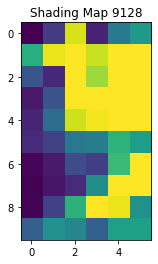

In [3]:
"""Load in Dataset (training_data.csv)"""
read_in = pd.read_csv("shading_series.csv")
def convert_to_array(string):
    a = np.matrix(string).reshape(10, 6)
    a = np.array(a)
    return a
shading_series = [convert_to_array(s) for s in read_in['Shading Maps']]
s = random.randint(0, 10000)
plt.imshow(shading_series[s])
plt.title("Shading Map " + str(s))

In [4]:
read_in = pd.read_csv("embedding_series.csv", header=0, names=['SuperString'], usecols=[1])
configurations = [x for x in read_in['SuperString']]


In [5]:
""" Create dataset data frame """
df = pd.read_csv("training_data.csv",dtype={'MPP':float, 'VMP':float, 'IMP':float, 'VOC':float, 'ISC':float, 'FF':float})
print(df)

         Shading Map #  SuperString #         MPP    VMP         IMP    VOC  \
0                    0              0  227.435930   0.67  339.456612   0.75   
1                    0              1   14.058677   3.59    3.916066   3.78   
2                    0              2  179.316049   0.67  267.635894   0.76   
3                    0              3  185.737293   0.67  277.219840   0.76   
4                    0              4  143.931344   0.67  214.822901   0.76   
...                ...            ...         ...    ...         ...    ...   
3706427           3813            834   30.880000   3.41    9.060000   3.84   
3706428           3813            835    0.040000  19.00    0.000000  37.99   
3706429           3813            836    0.040000  18.99    0.000000  37.98   
3706430           3813            837   20.290000   2.08    9.760000   2.30   
3706431           3813            838    0.040000  19.74    0.000000  39.48   

                ISC        FF  
0        353.587870

In [6]:
"""Create Normalised Column"""
normalised = []
for idx, x in enumerate(df['Shading Map #']):
    shading_map = shading_series[x].flatten()
    mpp = df.iloc[idx, 2]
    normalised.append(mpp/sum(shading_map))

In [7]:
print(max(normalised))

0.6449678511000733


In [8]:
df['Normalised MPP'] = normalised
print(df)

         Shading Map #  SuperString #         MPP    VMP         IMP    VOC  \
0                    0              0  227.435930   0.67  339.456612   0.75   
1                    0              1   14.058677   3.59    3.916066   3.78   
2                    0              2  179.316049   0.67  267.635894   0.76   
3                    0              3  185.737293   0.67  277.219840   0.76   
4                    0              4  143.931344   0.67  214.822901   0.76   
...                ...            ...         ...    ...         ...    ...   
3706427           3813            834   30.880000   3.41    9.060000   3.84   
3706428           3813            835    0.040000  19.00    0.000000  37.99   
3706429           3813            836    0.040000  18.99    0.000000  37.98   
3706430           3813            837   20.290000   2.08    9.760000   2.30   
3706431           3813            838    0.040000  19.74    0.000000  39.48   

                ISC        FF  Normalised MPP  
0  

In [32]:
vmp_filtered = df.loc[df['VMP']>3]
vmp_filtered = vmp_filtered.loc[vmp_filtered['IMP']>0.1]
vmp_filtered = vmp_filtered.loc[df['Normalised MPP']>0.1]
print(vmp_filtered)


         Shading Map #  SuperString #        MPP    VMP        IMP    VOC  \
29                   0             29  51.704728  35.80   1.444266  36.39   
87                   0             87  55.378736  40.17   1.378609  40.86   
94                   0             94  40.152784  20.74   1.936007  21.24   
96                   0             96  54.426668  39.48   1.378588  40.16   
138                  0            139  41.021058  24.51   1.673646  25.02   
...                ...            ...        ...    ...        ...    ...   
3706396           3813            801  61.980000   5.04  12.300000   5.46   
3706410           3813            816  70.490000  10.30   6.840000  10.67   
3706421           3813            827  65.080000  26.12   2.490000  26.72   
3706422           3813            828  46.790000  13.34   3.510000  13.80   
3706425           3813            832  92.020000   7.99  11.520000   8.61   

               ISC        FF  Normalised MPP  
29        1.448993  0.980577

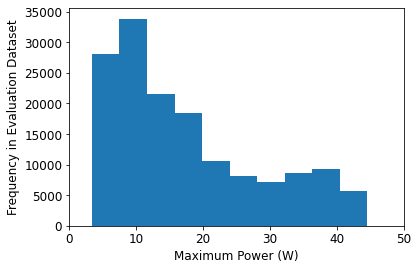

In [31]:
fig, ax = plt.subplots()
ax.hist(vmp_filtered['VMP'], color='C0')
#ax.hist(p_list, color='C1')
ax.set_xlabel('Maximum Power (W)',fontsize='large')
ax.set_ylabel('Frequency in Evaluation Dataset',fontsize='large')
ax.tick_params(axis='both', labelsize='large')
ax.set_xlim(0,50)
fig.savefig('histogram.png',dpi=300,bbox_inches="tight")

In [33]:
""" Create custom dataset """

class CustomDataset(Dataset):
    def __init__(self, df, rotate=None):
        self.df = df
        self.rotate = rotate # for rotation of shading maps?

    def __getitem__(self, index):
        shading_map = self.df.iloc[index, 0]
        shading_map = shading_series[shading_map]
        #print(shading_map)
        shading_map = torch.Tensor(shading_map)/10
        shading_map = shading_map.unsqueeze(0)
        
        x = self.df.iloc[index, 1]
        x = configurations[x]
        #print(x)
        x = super_to_embedding(10, 6, x) # superstring to boolean embedding
        embedding = x.embedding
        terminal_array = x.terminal_array
        embedding = embedding.flatten()
        terminal_array = terminal_array.flatten()
        
        label = np.append(embedding, terminal_array)
        label = torch.Tensor(label)
        
        power = self.df.iloc[index, -1]
        
        return shading_map, label, power 
        
    def __len__(self):
        return len(self.df['Shading Map #'])
dataset = CustomDataset(vmp_filtered)
print(dataset.__getitem__(2))
print(dataset.__getitem__(2)[0].shape, dataset.__getitem__(2)[1].shape)
print(len(dataset))


(tensor([[[0.5388, 0.4008, 0.1380, 0.0591, 0.0493, 0.0000],
         [0.9790, 0.8180, 0.3351, 0.2661, 0.2037, 0.1675],
         [1.0000, 1.0000, 0.8147, 0.6537, 0.4895, 0.3219],
         [0.9527, 1.0000, 1.0000, 1.0000, 0.8311, 0.6636],
         [0.5848, 1.0000, 1.0000, 0.9921, 1.0000, 1.0000],
         [0.3187, 1.0000, 1.0000, 0.7917, 1.0000, 1.0000],
         [0.8081, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [0.4665, 0.4731, 0.4304, 0.6833, 1.0000, 1.0000],
         [0.7753, 0.5322, 0.1938, 0.4205, 0.6439, 0.6110],
         [0.4304, 0.2661, 0.1445, 0.5519, 0.7096, 0.3942]]]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), 0.10062161276000274)
torch.Size([1, 10, 6]) torch.Size([10920])
151280


In [34]:
""" Initialize Hyperparameters """
#10,000 iterations, batching of 32

#1e-3 learning rate

# vary each training parameter individually, run multiple experiments. Checkpoint each model, filename w/ parameters

batch_size = 32 # 32-64 is advisable
learning_rate = 1e-3 # sensitivity of gradient descent
num_epochs = 1 # iterations over entire dataset 


4727
torch.Size([10920])


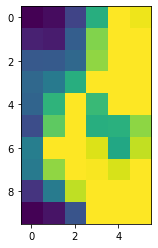

In [35]:
""" Dataloader """
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
print(len(train_dataloader))
x, y, p = next(iter(train_dataloader))
img = x[0].squeeze()
embedding = y[0].squeeze()
plt.imshow(img)
print(embedding.shape)

In [36]:
model = Model(imgshape=(10, 6)).to(device)
print(model)
print(device)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1920, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=10920, bias=True)
)
cpu


In [37]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
ratio_list = []
self_connections = []
conflicting_connections = []
loss_list = []

In [39]:
# iterate over epochs
entropy_loss = nn.MSELoss(reduction='none')
outfile = 'loss.csv'
with open(outfile, 'w', newline='') as f:
    writer = csv.writer(f)
    for epoch in range(num_epochs):

        # iterate over training dataset by batch
        for i, data in enumerate(train_dataloader, 0):

            shading_maps, embeddings, power = data
            shading_maps = shading_maps.to(device)
            result = model(shading_maps)
            """
            result = model(shading_maps)
            for j in range(batch_size):       
                result = model(shading_maps[j,...])[-1]
                label = embeddings[j]
                loss_ += entropy_loss(result.float(), label.float())
                break
            break
            """
            loss = torch.mean(entropy_loss(result, embeddings),axis=1)
            loss = torch.mean(loss*(1-power))
            
            average_ratio = 0
            self_c = 0
            conflicting_c = 0
            for j in range(0, batch_size):
                embedding = result[j]
                embedding = np.squeeze(embedding.detach())
                embedding, terminal_array = embedding[:10800], embedding[10800:]
                embedding = embedding.reshape(10, 6, 10, 6, 3)
                terminal_array = terminal_array.reshape(10, 6, 2)
                
                series_connections = torch.count_nonzero(embedding[...,0]) + torch.count_nonzero(embedding[...,1])
                parallel_connections = torch.count_nonzero(embedding[...,2])
                if parallel_connections == 0:
                    average_ratio += 0
                elif parallel_connections > 0:
                    average_ratio += (series_connections / parallel_connections)
                
                moduleobj = SolarModule(10, 6)
                moduleobj.embedding = np.array(embedding.numpy(), dtype=bool)
                moduleobj.terminal_array = np.array(terminal_array.numpy(), dtype=bool)
                filtering = moduleobj.filter_embedding()
                self_c += filtering[0]
                conflicting_c += filtering[1]
                
            average_ratio /= batch_size
            self_c /= batch_size
            conflicting_c /= batch_size
            ratio_list.append(float(average_ratio))
            self_connections.append(self_c)
            conflicting_connections.append(conflicting_c)
            
            loss_list.append(float(loss))
            
            writer.writerow([i, loss])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print(i, ratio_list[i], self_connections[i], conflicting_connections[i], loss)
            
            if self_connections[i] == 0 and conflicting_connections[i] == 0:
                break
            
        print('Epoch {}: Loss {}'.format(epoch, loss))

# create validation/evaluation batch of 10 or so shading maps, calculate the power from that
# visualise embeddings or circuit diagram against shading map

# use embeddings generated by superstrings for supervised approach. 
# pre-train on training_data.csv
# binary cross entropy between model and training data

# sort training_data.csv by performance (power)
# train same model by binary cross entropy
# use entire dataset, then use higher performing subset, then a subset of that, etc. 
# label = embedding

0 2.0973448753356934 97.90625 1787.125 tensor(0.0333, dtype=torch.float64, grad_fn=<MeanBackward0>)
1 1.1774482727050781 15.625 1251.75 tensor(0.0564, dtype=torch.float64, grad_fn=<MeanBackward0>)
2 0.8412561416625977 8.46875 591.53125 tensor(0.0290, dtype=torch.float64, grad_fn=<MeanBackward0>)
3 1.5306588411331177 49.0625 874.0625 tensor(0.0242, dtype=torch.float64, grad_fn=<MeanBackward0>)
4 1.5020935535430908 49.65625 1228.3125 tensor(0.0380, dtype=torch.float64, grad_fn=<MeanBackward0>)
5 1.1138899326324463 6.90625 1268.875 tensor(0.0166, dtype=torch.float64, grad_fn=<MeanBackward0>)
6 1.032000184059143 5.96875 1345.8125 tensor(0.0205, dtype=torch.float64, grad_fn=<MeanBackward0>)
7 0.9111194014549255 0.9375 1172.34375 tensor(0.0168, dtype=torch.float64, grad_fn=<MeanBackward0>)
8 0.8855326175689697 0.0 1093.28125 tensor(0.0286, dtype=torch.float64, grad_fn=<MeanBackward0>)
9 0.8400153517723083 0.40625 1017.53125 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
10 0.80

KeyboardInterrupt: 

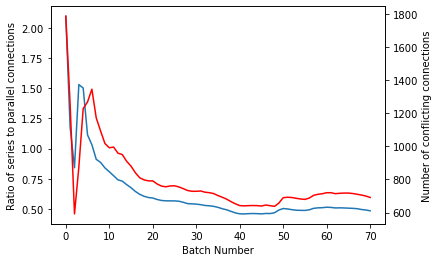

In [42]:
fig, ax1 = plt.subplots()
ax1.plot(ratio_list)
ax1.set_xlabel('Batch Number')
ax1.set_ylabel('Ratio of series to parallel connections')
#ax1.plot(self_connections)
ax2 = ax1.twinx()
ax2.plot(conflicting_connections, 'r')
ax2.set_ylabel('Number of conflicting connections')
#ax2.plot(loss_list, 'r')
plt.savefig('training_graph.png',dpi=300,bbox_inches="tight")

In [41]:
len(ratio_list)

71

In [ ]:
""" Model evaluation creation - DO NOT RUN"""
evaluation_shading_maps = pd.Series([generate_gaussian(10, 10, 6) for x in range(0, 100)])
print(evaluation_shading_maps)
filename = 'evaluation_series.csv'
with open(filename, 'w', newline='') as f:
    evaluation_shading_maps.to_csv(f, header=["Shading Maps"])

In [ ]:
""" Load in evaluation series"""
read_in = pd.read_csv("evaluation_series.csv", header=0, names=['Shading Maps'], usecols=[1])
eval_series = [convert_to_array(s) for s in read_in['Shading Maps']]

In [ ]:
class EvalDataset(Dataset):
    def __init__(self, series):
        self.series = series
    def __getitem__(self, index):
        shading_map = self.series[index]
        #print(shading_map)
        shading_map = torch.Tensor(shading_map)/10
        shading_map = shading_map.unsqueeze(0)
        return shading_map
    def __len__(self):
        return len(self.series)
evaldataset = EvalDataset(eval_series)
test_loader = torch.utils.data.DataLoader(evaldataset, batch_size=1)

In [ ]:
embedding_list = []
terminal_list = []
power_list = []
tct_list = []
sp_list = []
s_list = []
p_list = []

In [ ]:
''' evaluate model & visualise outputs'''
model.eval()
with torch.no_grad():
    # get single random image batch from test dataset
    for s in random.sample(list(test_loader), 100):
        
        # push images to gpu
        shading_map = s.to(device)
        # plot input image
        #plt.imshow(np.squeeze(shading_map))
        #plt.figure()
        # compute output image
        result = model(shading_map)
        #print(result)
        # get output image from gpu, reshape
        
        result = np.squeeze(result).cpu().numpy()
        embedding, terminal_array = result[:10800], result[10800:]        
        #print(embedding.shape)
        #print(terminal_array.shape)
        embedding = embedding.reshape(10, 6, 10, 6, 3)
        embedding = np.array(embedding, dtype=bool)
        
        embedding_list.append(np.copy(embedding)) # copy is required as filter_embedding() modifies both the embedding
                                                  # and the terminal array
        
        terminal_array = terminal_array.reshape(10, 6, 2)
        terminal_array = np.array(terminal_array, dtype=bool)
        
        terminal_list.append(np.copy(terminal_array))
        
        moduleobj = SolarModule(10,6)
        moduleobj.embedding = embedding
        moduleobj.terminal_array = terminal_array
        moduleobj.shading_map = np.squeeze(shading_map).cpu().numpy()*10
        denominator = sum(moduleobj.shading_map.flatten())
        
        #tct = TCT_interconnection(6, 10, moduleobj.shading_map)
        #sp = SP_interconnection(6, 10, moduleobj.shading_map)
        series = all_series_bypass(6, 10, moduleobj.shading_map)
        #tct.V('input', 6, series.gnd, 0)
        #sp.V('input', 1, series.gnd, 0)
        series.V('input', 1, series.gnd, 0)
        simulator = series.simulator(temperature=25, nominal_temperature=25)
        analysis = simulator.dc(Vinput=slice(0,50,0.01))
        #plt.plot(np.array(analysis.sweep), np.array(analysis.Vinput))
        bypassI = np.array(analysis.Vinput)
        bypassV = np.array(analysis.sweep)
        bypassP = bypassI * bypassV
        s_list.append(max(bypassP)/denominator)
        
        try:
            moduleobj.make_netlist()
        except ValueError:
            print(moduleobj.filter_embedding())
            moduleobj.make_netlist()
        try:
            moduleobj.simulate()
            normal_power = moduleobj.MPP/denominator
            power_list.append(round(normal_power, 2))
            p_list.append(round
                          (moduleobj.MPP, 2))
            print("{}, {} W, {} V, {} A".format(round(normal_power, 2), round(moduleobj.MPP, 2), \
                                            round(moduleobj.VMP, 2), round(moduleobj.IMP, 2)))
        #moduleobj.plot_netlist(ymax=300)
        #moduleobj.imshow(3, 3)
        except:
            power_list.append(0)
            p_list.append(0)
            print("Simulation failed")       
        
        print()

In [ ]:
# comparing evaluation embeddings predicted by model to 1000 embeddings in dataset.
thousand_modules = [super_to_embedding(10, 6, x) for x in configurations]
benchmark = [np.append(x.embedding.flatten(), x.terminal_array.flatten()) for x in thousand_modules]
print(benchmark[0].shape)    
comparison = [np.append(embedding_list[x].flatten(), terminal_list[x].flatten()) for x in range(0, len(embedding_list))]
print(len(comparison))
print(len(comparison[0]))

difference_list = []
for model_output in comparison:
    difference = []
    for array in benchmark:
        value = sum(model_output ^ array)
        print(value)
        difference.append(value)
    difference_list.append(difference)

In [ ]:
for x in difference_list:
    print(x.index(min(x)), end=' ')

In [ ]:
print(min(x))

In [ ]:
r, c = 2,0
plt.imshow(embedding_list[0][r,c,...,2])
plt.figure()
plt.imshow(embedding_list[34][r,c,...,2])
plt.figure()
plt.imshow(embedding_list[72][r,c,...,2])

In [ ]:
fig, ax = plt.subplots()
ax.hist(p_list, color='C1')
ax.set_xlabel('Maximum Power (W)',fontsize='large')
ax.set_ylabel('Frequency in Evaluation Dataset',fontsize='large')
ax.tick_params(axis='both', labelsize='large')
ax.set_xlim(0,300)
fig.savefig('histogram.png',dpi=300,bbox_inches="tight")

In [ ]:
''' save model checkpoint '''

# set model checkpoint path inc. hyperparams
_path = 'Checkpoints/Batch42FromInit.pth'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
}, _path)


In [ ]:
""" load model checkpoint """
''' load model checkpoint from file '''

# init model and optimiser
#model = TheModelClass(*args, **kwargs)
#optimizer = TheOptimizerClass(*args, **kwargs)

#_path = '../data/model/cnn-vae-f16-k5-z128-i121-v01.pth'
#_path = '../data/model/cnn-vae-f16-k3-z128-i115-v01.pth'
_path = 'supervised-f8-k3-z256-conflict4-no351.pth'

# load checkpoint
checkpoint = torch.load(_path)

# update model
#model.load_state_dict(checkpoint['model_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])

# update optimiser
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# set epoch and loss
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# set model train/eval state
#model.eval()
#model.train()

In [ ]:
new_eval_shading_maps = pd.Series([generate_gaussian(10, 10, 6) for x in range(0, 100)])
#print(new_eval_shading_maps)
filename = 'new_eval_shading_maps.csv'
with open(filename, 'w', newline='') as f:
    new_eval_shading_maps.to_csv(f, header=["Shading Maps"])
read_in = pd.read_csv("new_eval_shading_maps.csv", header=0, names=['Shading Maps'], usecols=[1])
new_eval_series = [convert_to_array(s) for s in read_in['Shading Maps']]

In [ ]:
filename = 'conflict4-no351_embedding_simulations.csv'
with open(filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Embedding No.', 'Map No.', 'Normalised Power', 'MPP', 'VMP', 'IMP', 'Filtered Embedding?'])
    for embedding_no, embedding in enumerate(embedding_list):
        
        terminal_array = terminal_list[embedding_no] # get corresponding terminal array for embedding
        
        moduleobj = SolarModule(10,6)
        moduleobj.embedding = np.copy(embedding)
        moduleobj.terminal_array = np.copy(terminal_array)
        
        try:
            moduleobj.make_netlist()
            modified = False
        except ValueError:
            moduleobj.filter_embedding()
            moduleobj.make_netlist()
            modified = True
        
        for map_no, shading_map in enumerate(new_eval_series):
            moduleobj.shading_map = shading_map
            denominator = sum(moduleobj.shading_map.flatten())
            moduleobj.make_netlist()
            moduleobj.simulate()
            normal_power = moduleobj.MPP/denominator
            print("embedding {}, shading map {}, {} %, {} W, {} V, {} A, modified {}".format(embedding_no, map_no, \
                                            round(normal_power, 2), round(moduleobj.MPP, 2), \
                                            round(moduleobj.VMP, 2), round(moduleobj.IMP, 2), modified))
            writer.writerow([embedding_no, map_no, round(normal_power, 2), round(moduleobj.MPP, 2), \
                            round(moduleobj.VMP, 2), round(moduleobj.IMP, 2), modified])